## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
print(ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
OBJECT_MODEL_PATH = os.path.join(ROOT_DIR, "logs/mask_rcnn_coco_0172.h5")

/home/ritu/Desktop/DETECT/Mask_RCNN_TF_Keras_nucoco_RROI_EARLY_RANDOM/Mask_RCNN-master


Using TensorFlow backend.


## Configurations

In [2]:
# Path of Dataset
import nucoco
config = nucoco.CocoConfig()
COCO_DIR = "/home/ritu/Desktop/DETECT/Datasets/nucoco"

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1600
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1600 1600    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0008
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Build validation dataset
print(config.NAME)
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset = nucoco.CocoDataset()
    dataset.load_coco(COCO_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

coco
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
Images: 710
Classes: ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'bus', 'truck']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
if config.NAME == "shapes":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = OBJECT_MODEL_PATH#COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

W1016 01:15:10.260468 139808582207232 deprecation_wrapper.py:119] From /home/ritu/anaconda3/envs/nuscenes/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



mode in build  inference


W1016 01:15:12.206922 139808582207232 deprecation.py:323] From /home/ritu/Desktop/DETECT/Mask_RCNN_TF_Keras_nucoco_RROI_EARLY_RANDOM/Mask_RCNN-master/mrcnn/model.py:407: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1016 01:15:12.211158 139808582207232 deprecation.py:506] From /home/ritu/Desktop/DETECT/Mask_RCNN_TF_Keras_nucoco_RROI_EARLY_RANDOM/Mask_RCNN-master/mrcnn/model.py:432: calling crop_and_resize_v1 (from tensorflow.python.ops.image_ops_impl) with box_ind is deprecated and will be removed in a future version.
Instructions for updating:
box_ind is deprecated, use box_indices instead
W1016 01:15:12.477710 139808582207232 deprecation_wrapper.py:119] From /home/ritu/Desktop/DETECT/Mask_RCNN_TF_Keras_nucoco_RROI_EARLY_RANDOM/Mask_RCNN-master/mrcnn/model.py:776: The name tf.sets.set_intersection is deprec

Loading weights  /home/ritu/Desktop/DETECT/Mask_RCNN_TF_Keras_nucoco_RROI_EARLY_RANDOM/Mask_RCNN-master/logs/mask_rcnn_coco_0172.h5


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [8]:
image_id = random.choice(dataset.image_ids)
print("", image_id)
image, image_meta, gt_class_id, gt_bbox =\
    modellib.load_image_gt(dataset, config, image_id, 0, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

 613
image ID: coco.10000151 (613) http://cocodataset.org/#explore?id=10000151


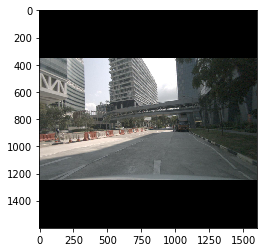

In [9]:
##IMAGE
plt.imshow(image)

no. of points 121


(-0.5, 1599.5, 1599.5, -0.5)

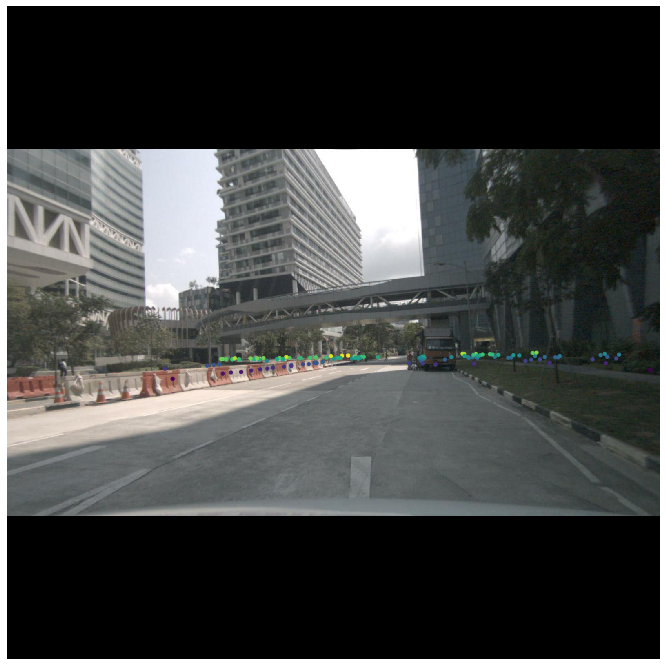

In [10]:
##RADAR POINT MAPPING ON IMAGE

pointclouds = dataset.image_info[image_id]["pointclouds"]
points = pointclouds['points']
print("no. of points", len(points))

x, y, z = np.array(points).T
dot_size = 10

plt.figure(figsize=(12,12))
plt.imshow(image)
plt.scatter(x, (350+y), c=z, s=dot_size)
plt.axis('off')

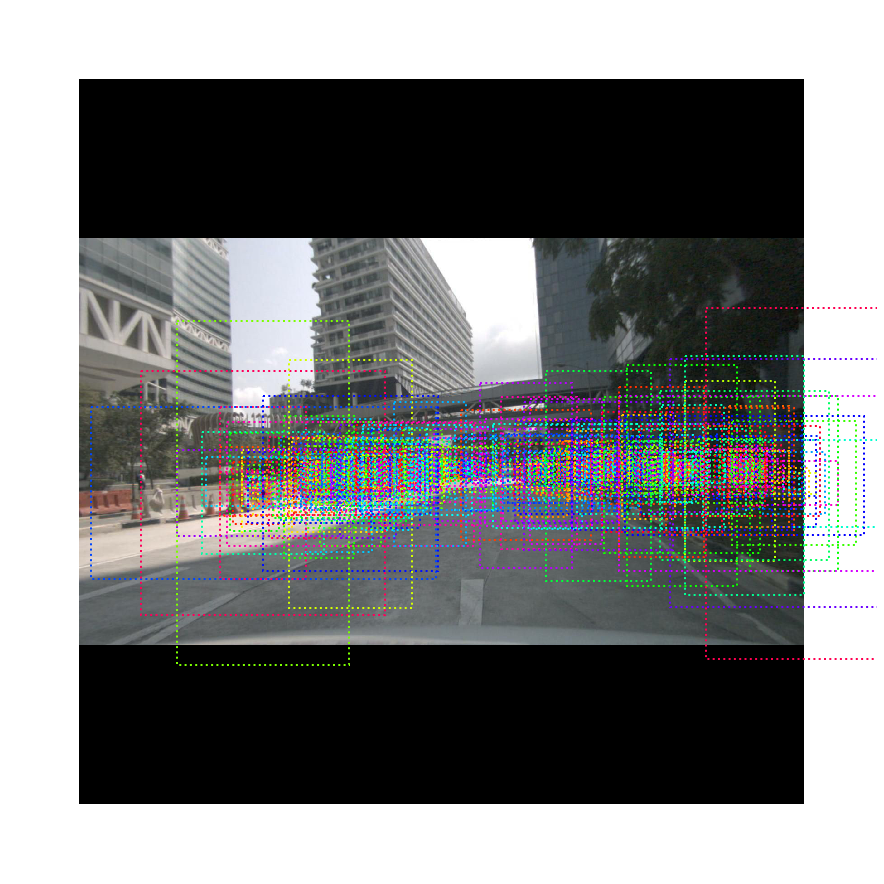

In [11]:
##ROI ANCHORS ON RADAR POINTS (LEFT, RIGHT, TOP, LESS ON BOTTOM)
include_depth = 0
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
##Fusion2##
h = dataset.image_info[image_id]["height"]
w = dataset.image_info[image_id]["width"]
rroi, ranchor_index = utils.rpoint_image_mapping(points, (h, w), (1600,1600), config)

visualize.draw_boxes(image, points, boxes=rroi, ax=get_ax())

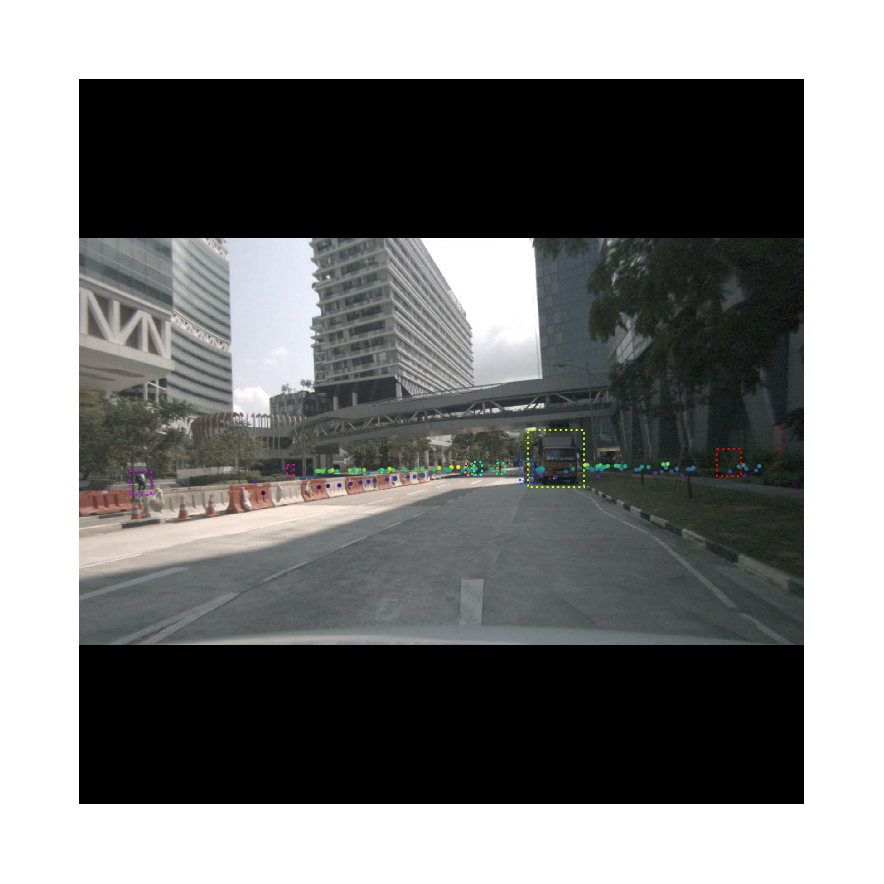

In [12]:
##GROUND TRUTH OBJECT BBOX
visualize.draw_boxes(image, points, boxes=gt_bbox, ax=get_ax())

target_rpn_match         shape: (639375,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:  -13.92899  max:    3.99459  float64
positive_anchors         shape: (9, 4)                min:   24.25785  max: 1459.91773  float64
negative_anchors         shape: (247, 4)              min:    0.00000  max:  869.87867  float64
neutral anchors          shape: (639119, 4)           min:    0.00000  max: 1963.87818  float64


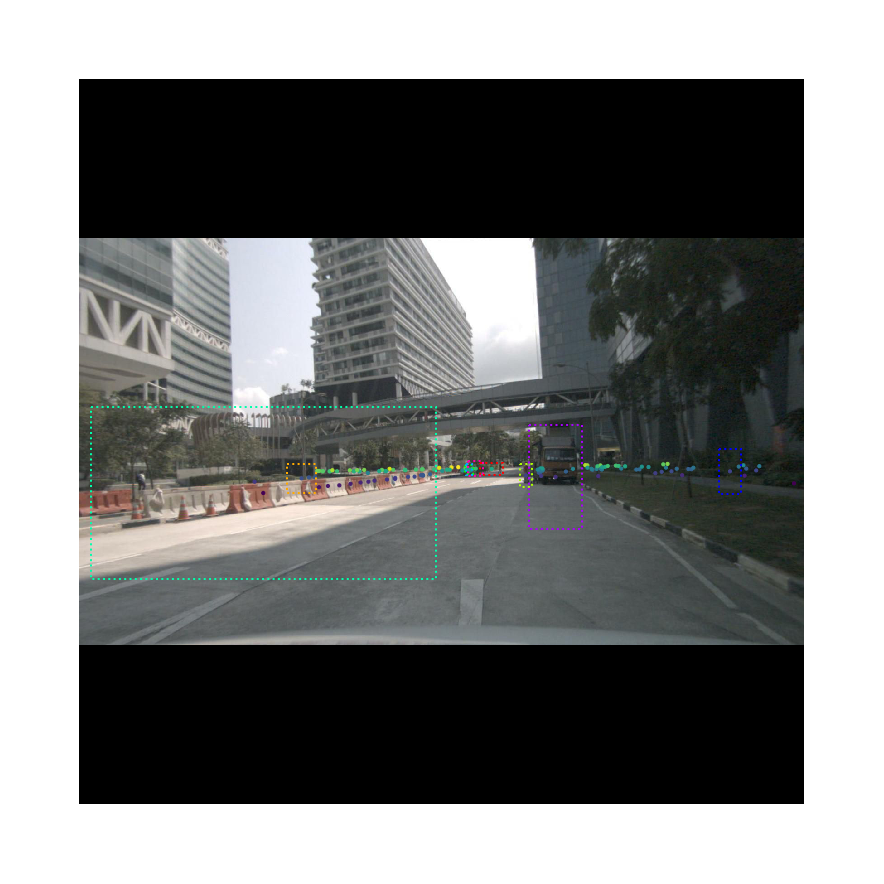

In [13]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.t_build_rpn_targets(
    image.shape, rroi, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = rroi[positive_anchor_ix]
negative_anchors = rroi[negative_anchor_ix]
neutral_anchors = rroi[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

visualize.draw_boxes(image, points, boxes=positive_anchors, ax=get_ax())

refined_anchors          shape: (9, 4)                min:  110.00000  max: 1460.00000  float32


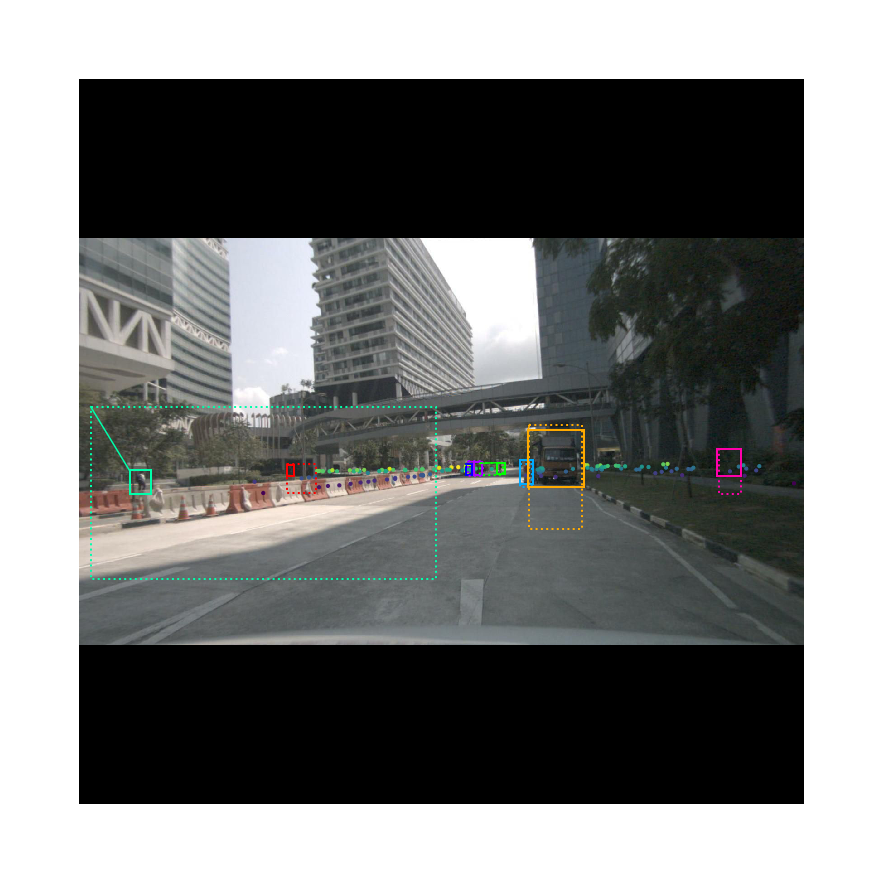

In [14]:
# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

visualize.draw_boxes(image, points, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

# Run Detection

Processing 1 images
image                    shape: (1600, 1600, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1600, 1600, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1600.00000  int64
anchors                  shape: (1, 639375, 4)        min:   -0.22642  max:    1.18639  float32
gt_class_id              shape: (10,)                 min:    1.00000  max:    6.00000  int32
gt_bbox                  shape: (10, 4)               min:  110.00000  max: 1460.00000  int32


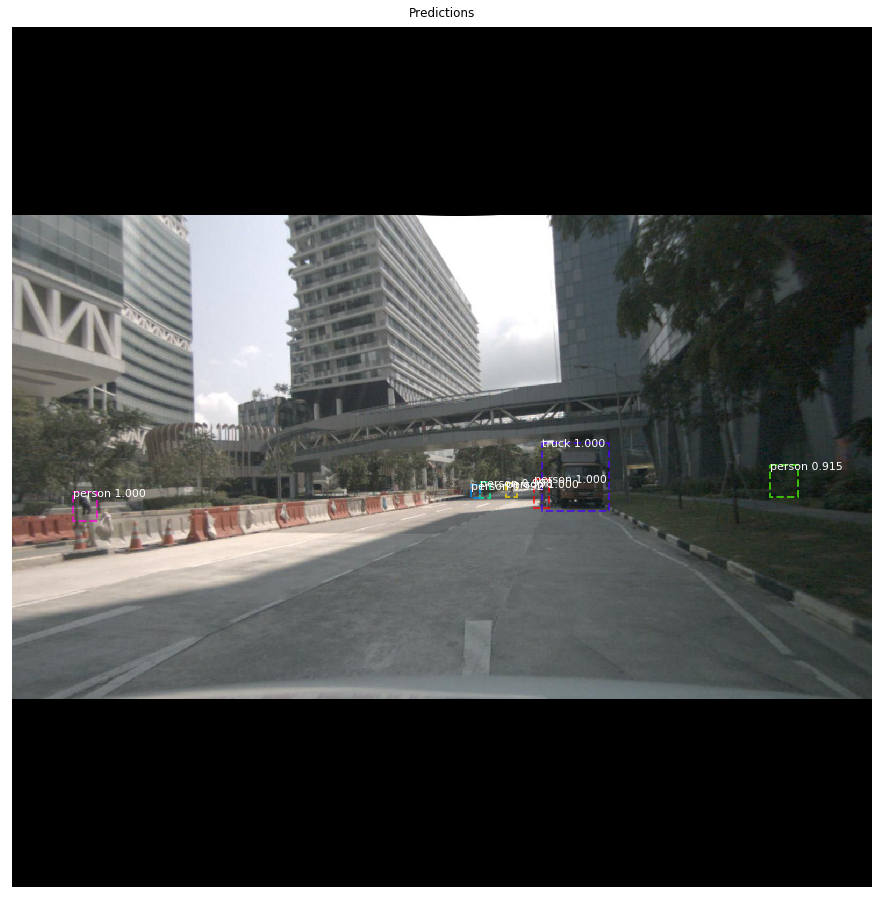

In [15]:
# Run object detection
results = model.detect([image], rroi, verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'],r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)

### Precision-Recall

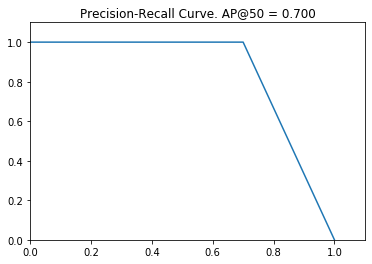

In [16]:
# Draw precision-recall curve
# AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                                           r['rois'], r['class_ids'], r['scores'], r['masks'])
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id,
                                          r['rois'], r['class_ids'], r['scores'])
visualize.plot_precision_recall(AP, precisions, recalls)

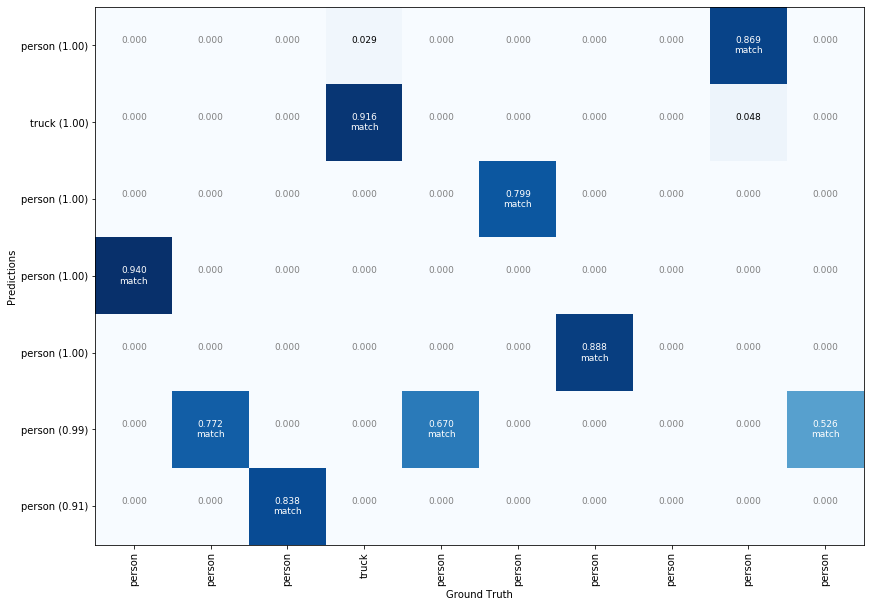

In [17]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [18]:
# # Compute VOC-style Average Precision
# def compute_batch_ap(image_ids):
#     APs = []
#     for image_id in image_ids:
#         # Load image
#         image, image_meta, gt_class_id, gt_bbox =\
#             modellib.load_image_gt(dataset, config,
#                                    image_id, 0, use_mini_mask=False)
#         rroi, ranchor_index = utils.rpoint_image_mapping(points, (h, w), (1600, 1600), config)
#         # Run object detection
#         results =  model.detect([image], rroi, verbose=0)
#         # Compute AP
#         r = results[0]
#         AP, precisions, recalls, overlaps =\
#             utils.compute_ap(gt_bbox, gt_class_id,
#                               r['rois'], r['class_ids'], r['scores'])
#         APs.append(AP)
#     return APs

# # Pick a set of random images
# image_ids = np.random.choice(dataset.image_ids, 50)
# APs = compute_batch_ap(image_ids)
# print("mAP @ IoU=50: ", np.mean(APs))